In [1]:
from chromatic_fitting import *
import celerite2
from celerite2.theano import terms, GaussianProcess

Running chromatic_fitting v0.10.0!

This program is running on:
Python v3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy v1.21.6
chromatic v0.4.5
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


In [ ]:


class SHOModel(GPModel):

    def __init__(self, name="gp_sho", kernel='sho', independant_variable='time', **kw):
        super().__init__(kernel, name, independant_variable, **kw)
#         self.required_parameters = required_params[kernel]
#         self.independant_variable = independant_variable
#         self.set_defaults()
#         self.set_name(name)

    def __repr__(self):
        return "<chromatic GP (simple harmonic oscillator) model 🌈>"

    def setup_lightcurves(self, store_models: bool = False):
        """
        Create a GP model, given the stored parameters.
        [This should be run after .attach_data()]
        """

        datas, models = self.choose_model_based_on_optimization_method()
        kw = {"shape": datas[0].nwave}

        # if the model has a name then add this to each parameter's name
        if hasattr(self, "name"):
            name = self.name + "_"
        else:
            name = ""

        if not hasattr(self, "every_light_curve"):
            self.every_light_curve = {}
        if not hasattr(self, "initial_guess"):
            self.initial_guess = {}
            
        if store_models == True:
            self.store_models = store_models

        self.covar = {}
        
        parameters_to_loop_over = {}
        for p in self.parameters.keys():
            parameters_to_loop_over[p] = []

        for j, (mod, data) in enumerate(zip(models, datas)):
            if self.optimization == "separate":
                kw["i"] = j
                
            x = data.get(self.independant_variable)
            if self.independant_variable == "time":
                x = x.to_value("day")
            else:
                try:
                    x = x.to_value()
                except AttributeError:
                    pass
                
            with mod:
                for pname in parameters_to_loop_over.keys():
                    parameters_to_loop_over[pname].append(
                        self.parameters[pname].get_prior_vector(**kw)
                    )
                    
                gp_model, kernel, initial_guess = [], [],[]
                for i, w in enumerate(data.wavelength):
                    if len(np.shape(x)) > 1:
                        xi = x[i, :]
                    else:
                        xi = x

                    param_i = {}
                    for pname, param in parameters_to_loop_over.items():
                        if isinstance(self.parameters[pname], WavelikeFitted):
                            param_i[pname] = param[j][i]
                        else:
                            param_i[pname] = param[j]

                    kernel.append(terms.SHOTerm(sigma=param_i[f"{name}sigma"],
                                           rho=param_i[f"{name}rho"],
                                           Q=param_i[f"{name}Q"]))
                    
                    initial_gp = GaussianProcess(kernel[-1], 
                                                 mean=self.mean.get_prior(i + j), 
                                                 t=xi, 
                                                 diag=data.uncertainty[i]**2 + pm.math.exp(self.log_jitter.get_prior(i + j)), 
                                                 quiet=True)
                    initial_gp_predict = initial_gp.predict(data.flux[i], t=xi)
                    initial_guess.append(eval_in_model(initial_gp_predict))

                self.covar[f"wavelength_{j}"] = kernel

                if f"wavelength_{j}" not in self.every_light_curve.keys():
                    self.every_light_curve[f"wavelength_{j}"] = pm.math.zeros_like(initial_gp_predict)
                else:
                    self.every_light_curve[f"wavelength_{j}"] += pm.math.zeros_like(initial_gp_predict)
                    
                if f"wavelength_{j}" not in self.initial_guess.keys():
                    self.initial_guess[f"wavelength_{j}"] = np.array(initial_guess)
                else:
                    self.initial_guess[f"wavelength_{j}"] += np.array(initial_guess)
                    

class QuasiPeriodicModel(GPModel):

    def __init__(self, name="gp_qp", kernel="quasi_periodic", independant_variable='time', **kw):
        super().__init__(kernel, name=name, independant_variable=independant_variable, **kw)

    def __repr__(self):
        return "<chromatic GP (rotation kernel) model 🌈>"

    def setup_lightcurves(self, store_models: bool = False):
        """
        Create a GP model, given the stored parameters.
        [This should be run after .attach_data()]
        """

        datas, models = self.choose_model_based_on_optimization_method()
        kw = {"shape": datas[0].nwave}

        # if the model has a name then add this to each parameter's name
        if hasattr(self, "name"):
            name = self.name + "_"
        else:
            name = ""

        if not hasattr(self, "every_light_curve"):
            self.every_light_curve = {}
        if not hasattr(self, "initial_guess"):
            self.initial_guess = {}
            
        if store_models == True:
            self.store_models = store_models

        self.covar = {}
        
        parameters_to_loop_over = {}
        for p in self.parameters.keys():
            parameters_to_loop_over[p] = []

        for j, (mod, data) in enumerate(zip(models, datas)):
            if self.optimization == "separate":
                kw["i"] = j
                
            x = data.get(self.independant_variable)
            if self.independant_variable == "time":
                x = x.to_value("day")
            else:
                try:
                    x = x.to_value()
                except AttributeError:
                    pass
                
            with mod:
                for pname in parameters_to_loop_over.keys():
                    parameters_to_loop_over[pname].append(
                        self.parameters[pname].get_prior_vector(**kw)
                    )
                    
                gp_model, kernel, initial_guess = [], [],[]
                for i, w in enumerate(data.wavelength):
                    if len(np.shape(x)) > 1:
                        xi = x[i, :]
                    else:
                        xi = x

                    param_i = {}
                    for pname, param in parameters_to_loop_over.items():
                        if isinstance(self.parameters[pname], WavelikeFitted):
                            param_i[pname] = param[j][i]
                        else:
                            param_i[pname] = param[j]

                    kernel.append(terms.RotationTerm(
                        sigma=param_i[f"{name}sigma"],
                        period=param_i[f"{name}log_period"],
                        Q0=param_i[f"{name}Q0"],
                        dQ=param_i[f"{name}dQ"],
                        f=param_i[f"{name}f"]
                    ))
                    
                    initial_gp = GaussianProcess(kernel[-1], 
                                                 mean=self.mean.get_prior(i + j), 
                                                 t=xi, 
                                                 diag=data.uncertainty[i]**2 + pm.math.exp(self.log_jitter.get_prior(i + j)), 
                                                 quiet=True)
                    initial_gp_predict = initial_gp.predict(data.flux[i], t=xi)
                    initial_guess.append(eval_in_model(initial_gp_predict))

                self.covar[f"wavelength_{j}"] = kernel

                if f"wavelength_{j}" not in self.every_light_curve.keys():
                    self.every_light_curve[f"wavelength_{j}"] = pm.math.zeros_like(initial_gp_predict)
                else:
                    self.every_light_curve[f"wavelength_{j}"] += pm.math.zeros_like(initial_gp_predict)
                    
                if f"wavelength_{j}" not in self.initial_guess.keys():
                    self.initial_guess[f"wavelength_{j}"] = np.array(initial_guess)
                else:
                    self.initial_guess[f"wavelength_{j}"] += np.array(initial_guess)
           

In [ ]:
terms.SHOTerm.get_test_parameters()

In [ ]:
terms.RotationTerm(**terms.RotationTerm.get_test_parameters())

In [ ]:
terms.RotationTerm.get_test_parameters()

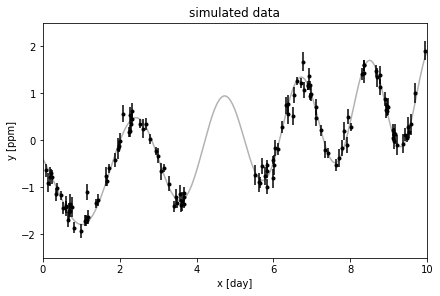

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

t = np.sort(
    np.append(
        np.random.uniform(0, 3.8, 57),
        np.random.uniform(5.5, 10, 68),
    )
)  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * np.random.randn(len(t))
)

true_t = np.linspace(0, 10, 500)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

🌈🤖 The time scale for this rainbow is '?',
and there are 125 time centers and
125 time edges defined.

It's hard to imshow something with a time axis
that isn't linearly or logarithmically uniform, or doesn't
at least have its time edges defined. We're giving up
and just using the time index as the time axis.

If you want a real time axis, one solution would
be to bin your times to a more uniform grid with
`rainbow.bin(dt=...)` (for linear times).



<Axes: xlabel='Time Index', ylabel='log$_{10}$[Wavelength/($\\mathrm{\\mu m}$)]'>

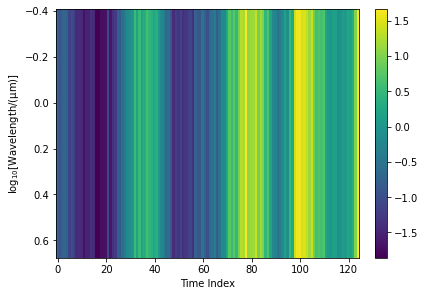

In [74]:
r = SimulatedRainbow(time=t*u.day, R=2)
r.flux *= y
r.uncertainty[:,:] = yerr
r.imshow()

In [75]:
r

<Simulated🌈(5w, 125t)>

In [324]:
from functools import partial

allowed_kernels = ['sho','quasi_periodic']
possible_params = {'sho':["sigma","rho","Q","w0","tau"],
                   'quasi_periodic': ["sigma","period","Q0","dQ","f"]
                  }
required_params = {'sho':["sigma"],
                   'quasi_periodic': ["sigma","period","Q0","dQ","f"]
                  }
defaults = {'sho':dict(sigma=1.0),
            'quasi_periodic':dict(sigma=1.0,period=1.0,dQ=1.0,Q0=1.0 / np.sqrt(2.0),f=0.0)
           }
kernel_func = {'sho':terms.SHOTerm, 'quasi_periodic':terms.RotationTerm}   

class GPModel(LightcurveModel):
    def __init__(self, 
                 kernel,
                 name="gp",
                 independant_variable='time', 
                 type_of_model: str = "systematic",
                 mean=0,
                 **kw):
        
        if kernel in allowed_kernels:
            self.kernel = kernel
        else:
            warnings.warn(
                f"{kernel} is not a valid type of model. Please select one of: {allowed_kernels}"
            )
        
        if type_of_model in allowed_types_of_models:
            self.type_of_model = type_of_model
        else:
            warnings.warn(
                f"{type_of_model} is not a valid type of model. Please select one of: {allowed_types_of_models}"
            )
            
        super().__init__(**kw)
        self.required_parameters = required_params[kernel]
        self.possible_parameters = possible_params[kernel]
        self.independant_variable = independant_variable
        self.set_defaults()
        self.metadata = {}
        self.set_name(name)
        self.model = self.gp_model
        self.kernel_func = kernel_func[self.kernel]

    def set_defaults(self):
        self.defaults = defaults[self.kernel]

    def __repr__(self):
        return f"<chromatic GP model '{self.name}', with {self.kernel} kernel 🌈>"
    
    def setup_parameters(self,**kw):
        super().setup_parameters(**kw)
        
        # run quick check on parameters with kernel:
        test_params = {}
        for p in self.parameters.keys():
            test_params[p.replace(f"{self.name}_","")] = 0.1
        try:
            kernel_func[self.kernel](**test_params)
        except Exception as e:
            print(e)

    def add_jitter(self, log_jitter_parameter):
        self.log_jitter = log_jitter_parameter
        
    def add_mean(self, mean_parameter):
        self.mean = mean_parameter
        
    def setup_lightcurves(self, store_models: bool = False):
        """
        Create a GP model, given the stored parameters.
        [This should be run after .attach_data()]
        """

        datas, models = self.choose_model_based_on_optimization_method()
        kw = {"shape": datas[0].nwave}

        # if the model has a name then add this to each parameter's name
        if hasattr(self, "name"):
            name = self.name + "_"
        else:
            name = ""

        if not hasattr(self, "every_light_curve"):
            self.every_light_curve = {}
        if not hasattr(self, "initial_guess"):
            self.initial_guess = {}
        if not hasattr(self, 'mean'):
            warnings.warn("\nYou have not provided a mean to the GP. Are you sure this is right?\nIf you want to "\
                          "add a mean please run {self}.add_mean. We will proceed assuming a mean of 0.\n")
            self.mean = Fixed(0.0)
        if not hasattr(self, 'log_jitter'):
            warnings.warn("\nYou have not provided a jitter to the GP. Are you sure this is right?\nIf you want to "\
                          "add jitter please run {self}.add_jitter. We will proceed assuming no jitter.\n")
            self.log_jitter = Fixed(np.log(0.0))

        if store_models == True:
            self.store_models = store_models

        self.covar = {}
        
        parameters_to_loop_over = {}
        for p in self.parameters.keys():
            parameters_to_loop_over[p] = []

        for j, (mod, data) in enumerate(zip(models, datas)):
            if self.optimization == "separate":
                kw["i"] = j
                
            x = data.get(self.independant_variable)
            if self.independant_variable == "time":
                x = x.to_value("day")
            else:
                try:
                    x = x.to_value()
                except AttributeError:
                    pass
                
            with mod:
                for pname in parameters_to_loop_over.keys():
                    parameters_to_loop_over[pname].append(
                        self.parameters[pname].get_prior_vector(**kw)
                    )
                    
                gp_model, kernel, initial_guess = [], [],[]
                for i, w in enumerate(data.wavelength):
                    if len(np.shape(x)) > 1:
                        xi = x[i, :]
                    else:
                        xi = x

                    param_i = {}
                    for pname, param in parameters_to_loop_over.items():
                        if isinstance(self.parameters[pname], WavelikeFitted):
                            param_i[pname.replace(f"{self.name}_","")] = param[j][i]
                        elif isinstance(self.parameters[pname], Fixed):
                            param_i[pname.replace(f"{self.name}_","")] = param[0]
                        else:
                            param_i[pname.replace(f"{self.name}_","")] = param[j][0]

                    print(param_i)
                    kernel.append(self.kernel_func(**param_i))
                    
                    initial_gp = GaussianProcess(kernel[-1], 
                                                 mean=self.mean.get_prior(i + j), 
                                                 t=xi, 
                                                 diag=data.uncertainty[i]**2 + pm.math.exp(self.log_jitter.get_prior(i + j)), 
                                                 quiet=True)
                    initial_gp_predict = initial_gp.predict(data.flux[i], t=xi)
                    initial_guess.append(eval_in_model(initial_gp_predict))
                    
#                 print(eval_in_model(pm.math.zeros_like(pm.math.stack(initial_guess))))

                self.covar[f"wavelength_{j}"] = kernel

                if f"wavelength_{j}" not in self.every_light_curve.keys():
                    self.every_light_curve[f"wavelength_{j}"] = pm.math.zeros_like(pm.math.stack(initial_guess))
                else:
                    self.every_light_curve[f"wavelength_{j}"] += pm.math.zeros_like(pm.math.stack(initial_guess))
                    
                if f"wavelength_{j}" not in self.initial_guess.keys():
                    self.initial_guess[f"wavelength_{j}"] = np.array(initial_guess)
                else:
                    self.initial_guess[f"wavelength_{j}"] += np.array(initial_guess)

    
    def setup_likelihood(
        self,
        mask_outliers=False,
        mask_wavelength_outliers=False,
        sigma_wavelength=5,
        data_mask=None,
        inflate_uncertainties=False,
        setup_lightcurves_kw={},
        **kw,
    ):
        """
        Connect the light curve model to the actual data it aims to explain.
        """

        if hasattr(self, "every_light_curve"):
            if f"wavelength_0" not in self.every_light_curve.keys():
                print(".setup_lightcurves() has not been run yet, running now...")
                self.setup_lightcurves(**setup_lightcurves_kw)
        else:
            print(".setup_lightcurves() has not been run yet, running now...")
            self.setup_lightcurves(**setup_lightcurves_kw)

        datas, models = self.choose_model_based_on_optimization_method()

        # if the data has outliers, then mask them out
        if mask_outliers:
            # if the user has specified a mask, then use that
            if data_mask is None:
                # sigma-clip in time
                data_mask = np.array(get_data_outlier_mask(datas, **kw))
                if mask_wavelength_outliers:
                    # sigma-clip in wavelength
                    data_mask[
                        get_data_outlier_mask(
                            datas, clip_axis="wavelength", sigma=sigma_wavelength
                        )
                        == True
                    ] = True
                # data_mask_wave =  get_data_outlier_mask(data, clip_axis='wavelength', sigma=4.5)
            self.outlier_mask = data_mask
            self.outlier_flag = True
            self.data_without_outliers = remove_data_outliers(datas, data_mask)

        if inflate_uncertainties:
            self.parameters["nsigma"] = WavelikeFitted(
                Uniform, lower=1.0, upper=3.0, testval=1.01
            )
            self.parameters["nsigma"].set_name("nsigma")

        nsigma = []
        for j, (mod, data) in enumerate(zip(models, datas)):
            with mod:
                if inflate_uncertainties:
                    nsigma.append(
                        self.parameters["nsigma"].get_prior_vector(
                            i=j, shape=datas[0].nwave
                        )
                    )
                    uncertainty = [
                        np.array(data.uncertainty[i, :]) * nsigma[j][i]
                        for i in range(data.nwave)
                    ]
                    uncertainties = pm.math.stack(uncertainty)
                else:
                    uncertainties = np.array(data.uncertainty)

                # if the user has passed mask_outliers=True then sigma clip and use the outlier mask
                if mask_outliers:
                    flux = np.array(
                        [
                            self.data_without_outliers.flux[i + j, :]
                            for i in range(data.nwave)
                        ]
                    )
                else:
                    flux = np.array(data.flux)

#                 try:
                x = data.get(self.independant_variable)
                if self.independant_variable == "time":
                    x = x.to_value("day")
                        
                light_curve_name = f"wavelength_{j}"
                for i in range(data.nwave):
                    self.gp = GaussianProcess(self.covar[light_curve_name][i],
                                                  t=x,
                                                  diag=uncertainties[i] ** 2 + pm.math.exp(self.log_jitter.get_prior(i + j)),
                                                  mean=self.mean.get_prior(i + j),
                                                  quiet=True)

                    self.gp.marginal(f"gp_w{j+i}", observed=data.flux[i, :] - self.every_light_curve[light_curve_name][i])
#                     Deterministic(f"gp_pred_w{j+i}", self.gp.predict(flux[i] - self.every_light_curve[light_curve_name][i]))

#                 except Exception as e:
#                     print(e)        
                    
    def gp_model(self, y):
        return self.gp.predict(y=y)
    
    def generate_gp_model_from_params(self, params, i=0):
        new_params = {}
        for parname, par in params.items():
            if "interval" not in parname:
                parname_without_modelname = parname.replace(f"{p.name}_","")
                if f"[{i}]" in parname_without_modelname:
                    try:
                        new_params[parname_without_modelname.replace(f"[{i}]","")] = par[i]
                    except:
                        new_params[parname_without_modelname.replace(f"[{i}]","")] = par
                else:
                    try:
                        new_params[parname_without_modelname] = par[i]
                    except:
                        new_params[parname_without_modelname] = par
                
        extra_params = {}
        for name, default_value in zip(['log_jitter', 'mean'],[1.0,0.0]):
            if name in new_params.keys():
                extra_params[name] = new_params[name]
                new_params.pop(name)
            else:
                extra_params[name] = default_value
                
        kernel = p.kernel_func(**new_params)
        gp = GaussianProcess(kernel,
                                 mean=extra_params['mean'], 
                                 t=p.data.time.to_value('d'),
                                 diag=p.data.uncertainty[i,:]+np.exp(extra_params['log_jitter']))
        
        return gp


In [325]:
# set up polynomial model:
p = GPModel(kernel='sho')

p.setup_parameters(
    sigma = Fitted(Uniform,testval=1, lower=-1e6, upper=1e6),
    rho = Fitted(Uniform,testval=1,lower=-1e6, upper=1e6),
    tau = Fitted(Uniform, testval=10,lower=-1e6, upper=1e6),
)

# print a summary of all params:
p.summarize_parameters()

gp_sigma =
  <🧮 Fitted Uniform(testval=1, lower=-1000000.0, upper=1000000.0, name='gp_sigma') 🧮>

gp_rho =
  <🧮 Fitted Uniform(testval=1, lower=-1000000.0, upper=1000000.0, name='gp_rho') 🧮>

gp_tau =
  <🧮 Fitted Uniform(testval=10, lower=-1000000.0, upper=1000000.0, name='gp_tau') 🧮>



In [326]:
p.parameters

{'gp_sigma': <🧮 Fitted Uniform(testval=1, lower=-1000000.0, upper=1000000.0, name='gp_sigma') 🧮>,
 'gp_rho': <🧮 Fitted Uniform(testval=1, lower=-1000000.0, upper=1000000.0, name='gp_rho') 🧮>,
 'gp_tau': <🧮 Fitted Uniform(testval=10, lower=-1000000.0, upper=1000000.0, name='gp_tau') 🧮>}

In [327]:
p.attach_data(r)

In [328]:
p.add_jitter(Fitted(Normal,name='log_jitter', mu=-4, sigma=3))

In [329]:
p.setup_lightcurves()

/var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/ipykernel_8480/1107806959.py:92: UserWarning: 
You have not provided a mean to the GP. Are you sure this is right?
If you want to add a mean please run {self}.add_mean. We will proceed assuming a mean of 0.

  warnings.warn("\nYou have not provided a mean to the GP. Are you sure this is right?\nIf you want to "\


{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'rho': Subtensor{int64}.0, 'tau': Subtensor{int64}.0}


In [330]:
print(p._pymc3_model)

gp_sigma_interval__ ~ TransformedDistribution
  gp_rho_interval__ ~ TransformedDistribution
  gp_tau_interval__ ~ TransformedDistribution
         log_jitter ~ Normal
           gp_sigma ~ Uniform
             gp_rho ~ Uniform
             gp_tau ~ Uniform


<ErrorbarContainer object of 3 artists>

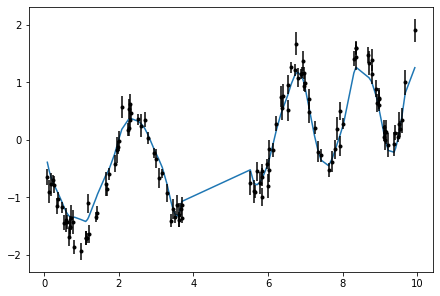

In [331]:
plt.plot(p.data.time, p.initial_guess['wavelength_0'][0])
plt.plot(p.data.time, p.data.flux[0,:],'k.')
plt.errorbar(p.data.time, p.data.flux[0,:], p.data.uncertainty[0,:], color='k', linestyle='None')

In [332]:
p.setup_likelihood()

optimizing logp for variables: [log_jitter, gp_tau, gp_rho, gp_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: -1019.1701480729821 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


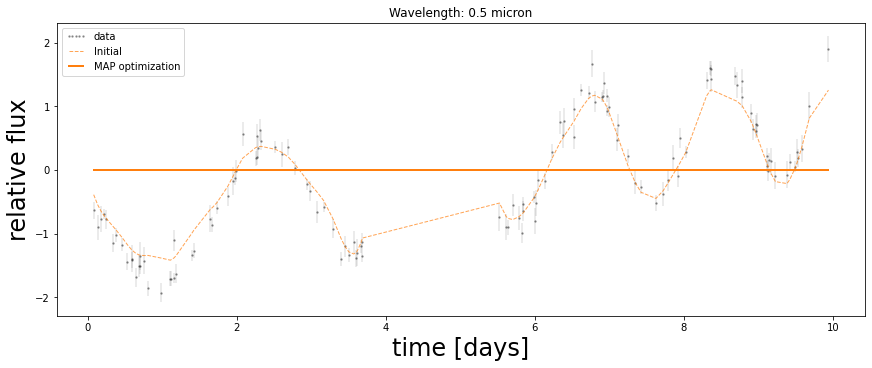

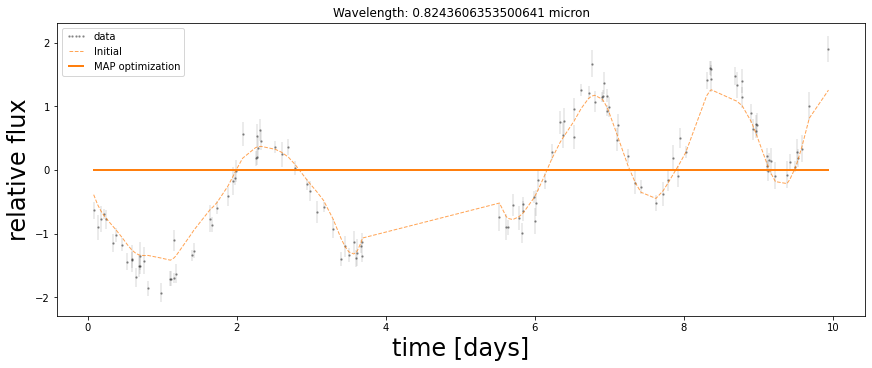

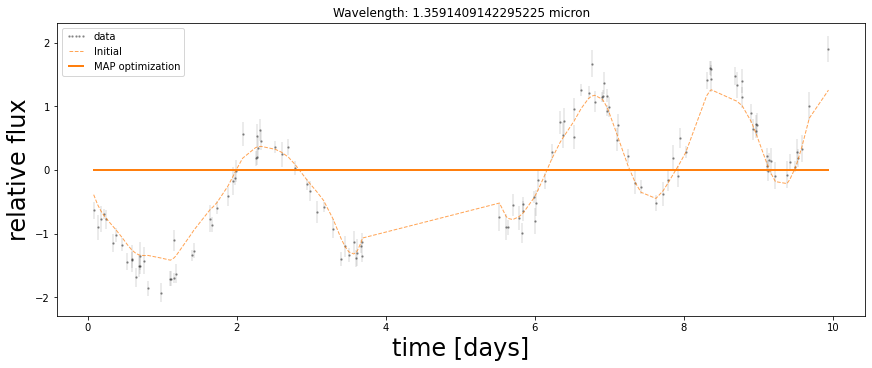

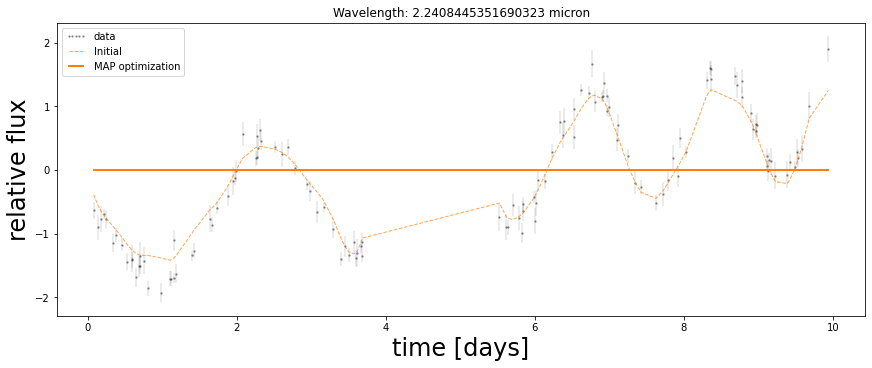

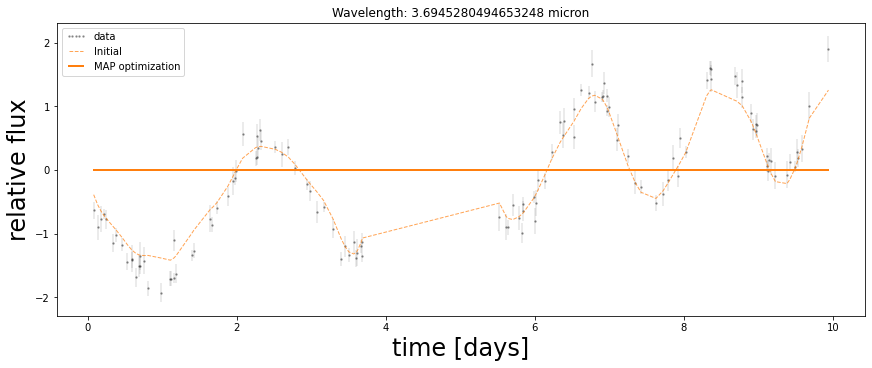

In [333]:
# optimize for initial values!
opt = p.optimize(plot=True)

In [334]:
# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains.
p.sample(sampling_method=pmx.sample, start=opt, tune=2000, draws=4000, chains=4, cores=4, return_inferencedata=False)

Sampling model using the <function sample at 0x7fd196561a60> method


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_jitter, gp_tau, gp_rho, gp_sigma]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 85 seconds.
The acceptance probability does not match the target. It is 0.9595215734800508, but should be close to 0.9. Try to increase the number of tuning steps.


                 mean        sd   hdi_16%   hdi_84%  mcse_mean   mcse_sd   
log_jitter  -7.891579  1.441216 -8.530867 -6.092664   0.017022  0.012457  \
gp_sigma[0]  1.085505  0.135018  0.930029  1.171231   0.001962  0.001493   
gp_rho[0]    2.798991  0.203353  2.561041  2.930880   0.002229  0.001634   
gp_tau[0]    1.804248  0.573576  1.199203  2.053671   0.010470  0.008996   

                 ess_bulk     ess_tail     r_hat  
log_jitter    9173.443660  7289.581643  1.000944  
gp_sigma[0]   6608.948662  4783.933760  1.000382  
gp_rho[0]    10524.908868  6945.319012  1.000192  
gp_tau[0]     6073.142404  3193.548271  1.000719  


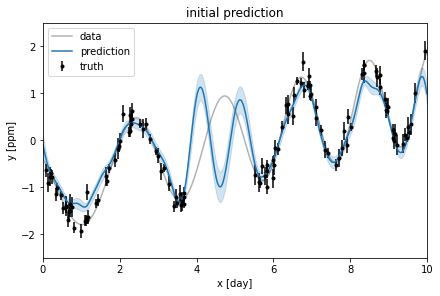

In [335]:
def plot_prediction(self, gp, plot_var=True, legend=True):
    plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="data")
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="truth")

    if gp:
        mu, variance = eval_in_model(gp.predict(y, t=true_t, return_var=True),model=self._pymc3_model)
        plt.plot(true_t, mu, label="prediction", c='C0')
        if plot_var:
            sigma = np.sqrt(variance)
            plt.fill_between(true_t, mu - sigma, mu + sigma, color="C0", alpha=0.2)

    plt.xlabel("x [day]")
    plt.ylabel("y [ppm]")
    plt.xlim(0, 10)
    plt.ylim(-2.5, 2.5)
    if legend:
        plt.legend()


plt.title("initial prediction")
plot_prediction(p, p.gp)

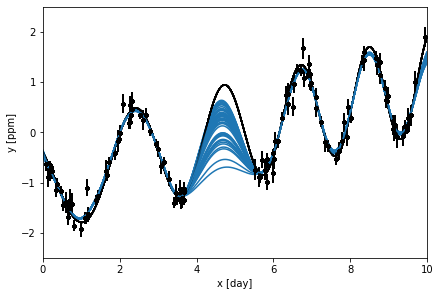

In [336]:
i=0
plt.figure()
for trace in p.trace[:50]:
    gp = p.generate_gp_model_from_params(trace, i=i)
    plot_prediction(p, gp, plot_var=False, legend=False)

In [337]:
results=p.summary['mean']
results = results.to_dict()
new_results = {}
for k,v in results.items():
    if "[0]" in k:
        new_results[k.replace('[0]','')] = v
    else:
        new_results[k] = v
        
new_results

{'log_jitter': -7.891579,
 'gp_sigma': 1.0855054,
 'gp_rho': 2.7989907,
 'gp_tau': 1.8042476}

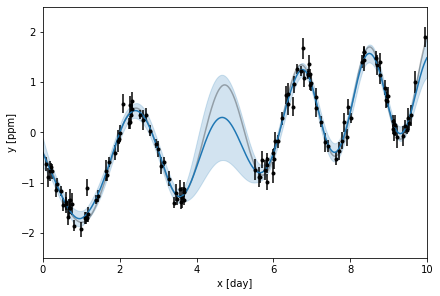

In [338]:
gp = p.generate_gp_model_from_params(p.summary['mean'])#new_results)
plot_prediction(p, gp, plot_var=True, legend=False)